<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#AR-Model" data-toc-modified-id="AR-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>AR Model</a></span></li><li><span><a href="#ARIMA-Model" data-toc-modified-id="ARIMA-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ARIMA Model</a></span></li><li><span><a href="#Facebook-Prophet" data-toc-modified-id="Facebook-Prophet-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Facebook Prophet</a></span></li></ul></div>

# Data Cleaning

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
orders_df = pd.read_csv('olist_orders_dataset.csv')
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
orders_df.drop(['order_status',
                'customer_id',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date'], axis='columns', inplace=True)
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
order_id                    99441 non-null object
order_purchase_timestamp    99441 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


In [12]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df.dtypes

order_id                            object
order_purchase_timestamp    datetime64[ns]
dtype: object

In [8]:
orders_df[orders_df.duplicated()]

,order_id,order_purchase_timestamp


In [9]:
orders_df.head()

,order_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


634

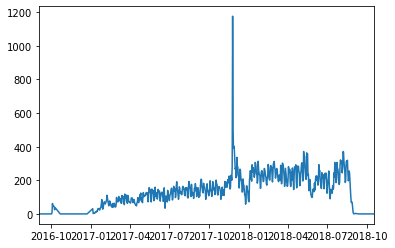

In [30]:
#plt.figure(figsize=(15,6))
orders_df['purchase_date'] = orders_df['order_purchase_timestamp'].dt.date
daily_sales_df = orders_df.groupby('purchase_date')['order_id'].count()
plt.plot(daily_sales_df)
plt.autoscale(enable=True, axis='x', tight=True)
daily_sales_df.shape[0]

In [25]:
test_size = int(daily_sales_df.shape[0] * 0.25)
train_df = daily_sales_df.iloc[:-test_size]
test_df = daily_sales_df.iloc[-test_size:]

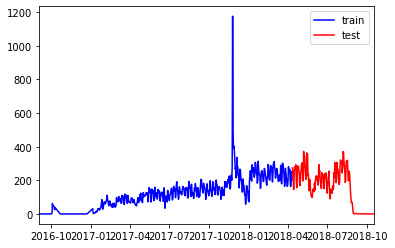

In [31]:
plt.plot(train_df, c='blue', label='train')
plt.plot(test_df, c='red', label='test')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

# AR Model

Lag: 2
Coefficients: const          27.538169
L1.order_id     0.627469
L2.order_id     0.186089
dtype: float64


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


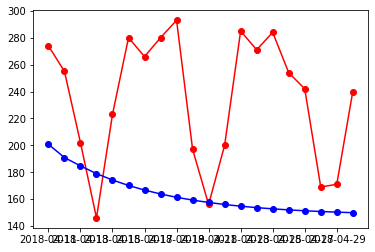

In [69]:
from statsmodels.tsa.ar_model import AR

ar = AR(train_df)
ar_fit = ar.fit(maxlag=2)

print('Lag: %s' % ar_fit.k_ar)
print('Coefficients: %s' % ar_fit.params)

predictions_lag2_20 = ar_fit.predict(start=len(train_df), end=len(train_df)+19)
predictions_lag2_20_df = pd.DataFrame({'predictions': predictions_lag2_20.values}, index=test_df[:20].index)


plt.plot(test_df[:20], c="red", label="test", marker='o')
plt.plot(predictions_lag2_20_df, c="blue", label="predict", marker='o')
#plt.legend()

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


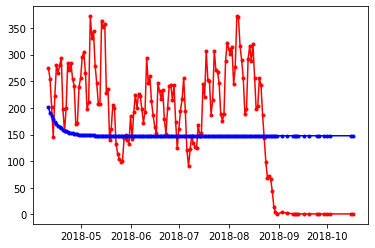

In [70]:
predictions_lag2 = ar_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
predictions_lag2_df = pd.DataFrame({'predictions': predictions_lag2.values}, index=test_df.index)

plt.plot(test_df, c="red", label="test", marker='.')
plt.plot(predictions_lag2_df, c="blue", label="predict", marker='.')

Lag: 10
Coefficients: const           13.578382
L1.order_id      0.508284
L2.order_id      0.026771
L3.order_id      0.084325
L4.order_id      0.063597
L5.order_id     -0.007114
L6.order_id      0.062850
L7.order_id      0.184195
L8.order_id      0.003505
L9.order_id     -0.063241
L10.order_id     0.051402
dtype: float64


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


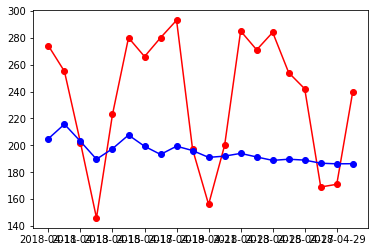

In [71]:
from statsmodels.tsa.ar_model import AR

ar = AR(train_df)
ar_fit = ar.fit(maxlag=10)

print('Lag: %s' % ar_fit.k_ar)
print('Coefficients: %s' % ar_fit.params)

predictions_lag10_20 = ar_fit.predict(start=len(train_df), end=len(train_df)+19)
predictions_lag10_20_df = pd.DataFrame({'predictions': predictions_lag10_20.values}, index=test_df[:20].index)


plt.plot(test_df[:20], c="red", label="test", marker='o')
plt.plot(predictions_lag10_20_df, c="blue", label="predict", marker='o')
#plt.legend()

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


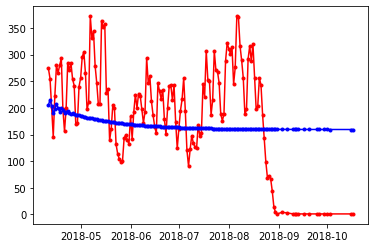

In [72]:
predictions_lag10 = ar_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
predictions_lag10_df = pd.DataFrame({'predictions': predictions_lag10.values}, index=test_df.index)

plt.plot(test_df, c="red", label="test", marker='.')
plt.plot(predictions_lag10_df, c="blue", label="predict", marker='.')

Lag: 6
Coefficients: const          16.301024
L1.order_id     0.532871
L2.order_id     0.018121
L3.order_id     0.106229
L4.order_id     0.085835
L5.order_id    -0.007317
L6.order_id     0.159369
dtype: float64


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


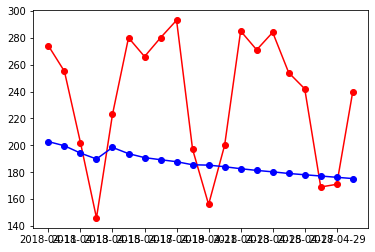

In [79]:
from statsmodels.tsa.ar_model import AR

ar = AR(train_df)
ar_fit = ar.fit(maxlag=6)

print('Lag: %s' % ar_fit.k_ar)
print('Coefficients: %s' % ar_fit.params)

predictions_lag10_20 = ar_fit.predict(start=len(train_df), end=len(train_df)+19)
predictions_lag10_20_df = pd.DataFrame({'predictions': predictions_lag10_20.values}, index=test_df[:20].index)


plt.plot(test_df[:20], c="red", label="test", marker='o')
plt.plot(predictions_lag10_20_df, c="blue", label="predict", marker='o')
#plt.legend()

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


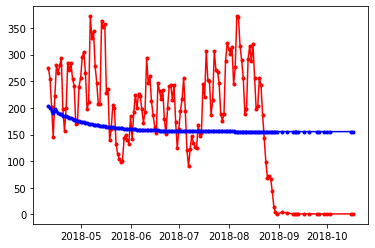

In [81]:
predictions_lag10 = ar_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
predictions_lag10_df = pd.DataFrame({'predictions': predictions_lag10.values}, index=test_df.index)

plt.plot(test_df, c="red", label="test", marker='.')
plt.plot(predictions_lag10_df, c="blue", label="predict", marker='.')

# ARIMA Model

In [114]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima = SARIMAX(train_df, order=(6, 2, 5),
                enforce_stationarity=False, 
                enforce_invertibility=False)
arima_fit = arima.fit()

print('Coefficients: %s' % arima_fit.params)

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Coefficients: ar.L1       -0.127446
ar.L2       -0.726578
ar.L3       -0.288987
ar.L4       -0.827635
ar.L5       -0.380490
ar.L6       -0.266750
ma.L1       -1.320000
ma.L2        0.854815
ma.L3       -0.483875
ma.L4        0.648539
ma.L5       -0.697805
sigma2    3241.562992
dtype: float64


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


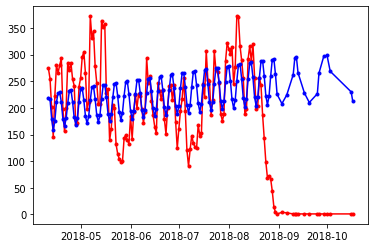

In [118]:
arima_predictions = arima_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
arima_predictions_df = pd.DataFrame({'predictions': arima_predictions.values}, index=test_df.index)

plt.plot(test_df, c="red", label="test", marker='.')
plt.plot(arima_predictions_df, c="blue", label="predict", marker='.')

In [119]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print("RMSE: ",sqrt(mean_squared_error(test_df, arima_predictions_df)))

RMSE:  106.13382645180907


# Facebook Prophet

In [123]:
daily_sales_df

purchase_date
2016-09-04    1
2016-09-05    1
2016-09-13    1
2016-09-15    1
2016-10-02    1
             ..
2018-09-29    1
2018-10-01    1
2018-10-03    1
2018-10-16    1
2018-10-17    1
Name: order_id, Length: 634, dtype: int64

In [126]:
sales_df = pd.DataFrame(orders_df.groupby('purchase_date')['order_id'].count())
daily_sales_prohpet_df = daily_sales_df.reset_index()
daily_sales_prohpet_df.columns = ['ds', 'y']
daily_sales_prohpet_df.head()

,ds,y
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


In [128]:
train_prophet_df = daily_sales_prohpet_df.iloc[:-test_size]
test_prophet_df = daily_sales_prohpet_df.iloc[-test_size:]

In [120]:
holidays = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2018-12-01', '2018-12-02', '2018-12-08',
                        '2018-12-09', '2018-12-13', '2018-12-15',
                        '2018-12-16', '2018-12-22', '2018-12-23',
                        '2018-12-24', '2018-12-25', '2018-12-26',
                        '2018-12-27', '2018-12-28']),
 
})

In [129]:
from fbprophet import Prophet 
prophet = Prophet(interval_width=0.95, holidays=holidays)
prophet.fit(train_prophet_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
future = prophet.make_future_dataframe(periods=test_size, freq='D' , include_history=False)

In [132]:
forecast = prophet.predict(future)

In [133]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,christmas,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-04-11,253.432736,155.333934,383.975030,253.432736,253.432736,11.200735,11.200735,11.200735,0.0,...,0.0,0.0,0.0,11.200735,11.200735,11.200735,0.0,0.0,0.0,264.633471
1,2018-04-12,253.857972,142.962833,378.445075,253.857369,253.860435,4.760145,4.760145,4.760145,0.0,...,0.0,0.0,0.0,4.760145,4.760145,4.760145,0.0,0.0,0.0,258.618117
2,2018-04-13,254.283207,145.700217,370.873151,254.279131,254.292646,2.941566,2.941566,2.941566,0.0,...,0.0,0.0,0.0,2.941566,2.941566,2.941566,0.0,0.0,0.0,257.224773
3,2018-04-14,254.708442,104.836769,335.231603,254.701947,254.724857,-31.566704,-31.566704,-31.566704,0.0,...,0.0,0.0,0.0,-31.566704,-31.566704,-31.566704,0.0,0.0,0.0,223.141738
4,2018-04-15,255.133678,113.931338,353.007838,255.118736,255.156284,-21.943819,-21.943819,-21.943819,0.0,...,0.0,0.0,0.0,-21.943819,-21.943819,-21.943819,0.0,0.0,0.0,233.189858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2018-09-11,318.493755,219.238532,451.095702,314.811578,322.461370,16.911316,16.911316,16.911316,0.0,...,0.0,0.0,0.0,16.911316,16.911316,16.911316,0.0,0.0,0.0,335.405071
154,2018-09-12,318.918990,228.029884,447.739763,315.216315,322.933828,11.200735,11.200735,11.200735,0.0,...,0.0,0.0,0.0,11.200735,11.200735,11.200735,0.0,0.0,0.0,330.119726
155,2018-09-13,319.344226,205.726726,436.279033,315.608409,323.419922,4.760145,4.760145,4.760145,0.0,...,0.0,0.0,0.0,4.760145,4.760145,4.760145,0.0,0.0,0.0,324.104371
156,2018-09-14,319.769461,211.192698,435.722939,316.007747,323.899873,2.941566,2.941566,2.941566,0.0,...,0.0,0.0,0.0,2.941566,2.941566,2.941566,0.0,0.0,0.0,322.711027


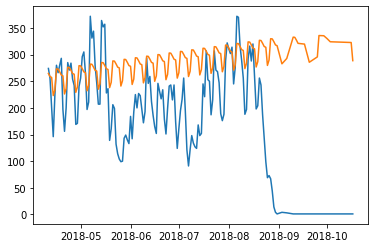

In [139]:
plt.plot(test_prophet_df['ds'], test_prophet_df['y'])
plt.plot(test_prophet_df['ds'], forecast['yhat']) 

In [146]:
print("RMSE: ", sqrt(mean_squared_error(test_prophet_df['y'], forecast['yhat'])))

RMSE:  138.1187942216656


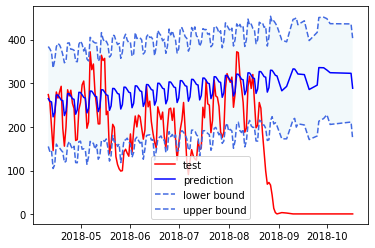

In [150]:
test = test_prophet_df
plt.plot(test['ds'], test['y'].values, c="red", label="test")
plt.plot(test['ds'], forecast['yhat'].values, c="blue", label="prediction")
plt.plot(test['ds'], forecast['yhat_lower'].values, c="royalblue", label="lower bound", linestyle='--')
plt.plot(test['ds'], forecast['yhat_upper'].values, c="royalblue", label="upper bound", linestyle='--')
ax = plt.gca()
ax.fill_between(test['ds'],  forecast['yhat_lower'], forecast['yhat_upper'], facecolor='lightblue', alpha=0.15, interpolate=True)
plt.legend()

The results show that the test data is contained within the upper and lower bounds of the uncertainty intervals.